# Phân loại Thời trang với CNN, KNN, và Logistic Regression (Hồi Quy)

Notebook này trình bày cách đào tạo và so sánh các mô hình khác nhau để phân loại thời trang.

## 1. Tất cả thư viện cần thiết

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## 2. Load từ CSV và định nghĩa nhãn tiếng Việt

In [6]:
# Tải dữ liệu MNIST thời trang từ các tệp CSV
train_df = pd.read_csv('dataset/fashion-mnist_train.csv')
test_df = pd.read_csv('dataset/fashion-mnist_test.csv')

# Trích xuất nhãn và hình ảnh
train_labels = train_df['label'].values
train_images = train_df.drop('label', axis=1).values.reshape(-1, 28, 28)

test_labels = test_df['label'].values
test_images = test_df.drop('label', axis=1).values.reshape(-1, 28, 28)

# Đặt tên lớp bằng tiếng Việt
class_names = ['Áo thun', 'Quần dài', 'Áo len', 'Váy', 'Áo khoác',
               'Guốc', 'Áo sơ mi', 'Giày sneaker', 'Túi', 'Ủng']

## 3. Chuẩn hóa và reshape dữ liệu

In [7]:
# Chuẩn hóa hình ảnh
train_images = train_images / 255.0
test_images = test_images / 255.0

# Định hình lại để thêm chiều kênh cho CNN
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Chia dữ liệu huấn luyện thành tập huấn luyện và tập xác thực
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42)

## 4. Build CNN Model

In [8]:
# Xây dựng mô hình CNN
model = models.Sequential([
    # Khối tích chập 2D đầu tiên
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    # Khối tích chập 2D thứ hai
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Khối tích chập 2D thứ ba
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Khối tích chập 2D thứ tư
    layers.Conv2D(128, (3, 3), activation='relu'),
    # Làm phẳng
    layers.Flatten(),
    # Lớp fully connected với ReLU
    layers.Dense(128, activation='relu'),
    # Khối dropout để giảm overfitting
    layers.Dropout(0.5),
    # Lớp fully connected với softmax cho phân loại đa lớp
    layers.Dense(10, activation='softmax')
])
# Tóm tắt mô hình
model.summary()

/home/criskun/Documents/Project_AI/DOAN/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,402 (575.79 KB)

 Trainable params: 147,402 (575.79 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Biên dịch và train Model

In [9]:
# Biên dịch mô hình
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Định nghĩa callback dừng sớm
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping])

Epoch 1/30


2025-09-24 23:44:57.915659: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 169344000 exceeds 10% of free system memory.


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.7720 - loss: 0.6183 - val_accuracy: 0.8545 - val_loss: 0.3872
Epoch 2/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.7720 - loss: 0.6183 - val_accuracy: 0.8545 - val_loss: 0.3872
Epoch 2/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.8619 - loss: 0.3839 - val_accuracy: 0.8760 - val_loss: 0.3355
Epoch 3/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.8619 - loss: 0.3839 - val_accuracy: 0.8760 - val_loss: 0.3355
Epoch 3/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - accuracy: 0.8868 - loss: 0.3200 - val_accuracy: 0.8948 - val_loss: 0.2859
Epoch 4/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - accuracy: 0.8868 - loss: 0.3200 - val_accuracy: 0.8948 - val_loss: 0.2859
Epoch 4/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.8967 - loss: 0.2877 - val_accuracy: 0.9018 - val_loss: 0.2654
Epoch 5/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.8967 - loss: 0.28

## 6. Đánh giá accuracy, classification report, confusion matrix

313/313 - 1s - 4ms/step - accuracy: 0.9108 - loss: 0.2553

Test accuracy: 0.9107999801635742
  1/313 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step
Test accuracy: 0.9107999801635742
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:

Classification Report:
              precision    recall  f1-score   support

     Áo thun       0.85      0.86      0.86      1000
    Quần dài       0.98      0.99      0.99      1000
      Áo len       0.89      0.85      0.87      1000
         Váy       0.92      0.93      0.92      1000
    Áo khoác       0.84      0.88      0.86      1000
        Guốc       0.99      0.97      0.98      1000
    Áo sơ mi       0.74      0.73      0.74      1000
Giày sneaker       0.93      0.98      0.95      1000
         Túi       0.99      0.98      0.98      1000
         Ủng       0.98      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10

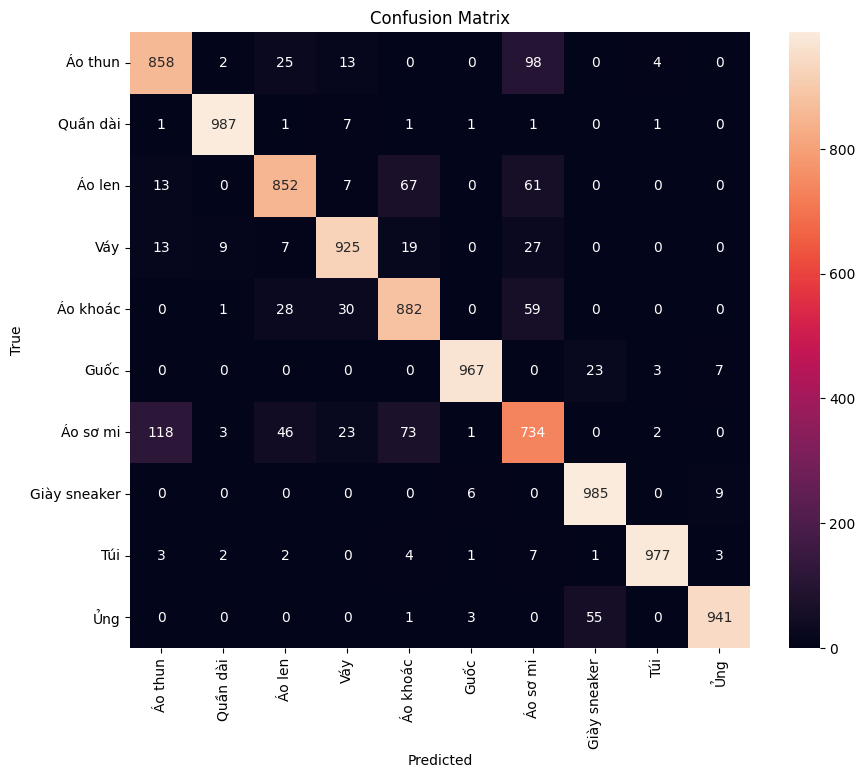

In [10]:
# Đánh giá mô hình trên tập kiểm tra
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Dự đoán nhãn cho tập kiểm tra
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Báo cáo phân loại
print('\nClassification Report:')
print(classification_report(test_labels, predicted_labels, target_names=class_names))

# Ma trận nhầm lẫn
print('\nConfusion Matrix:')
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 7. Biểu đồ accuracy và loss

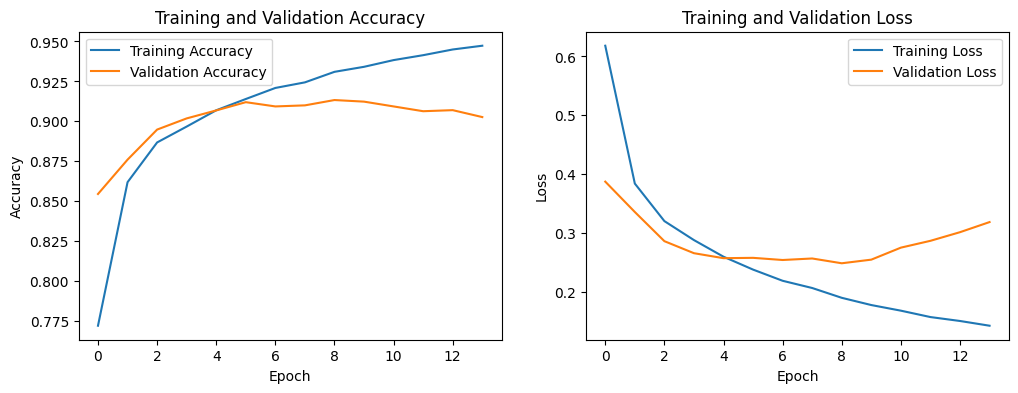

In [11]:
# Vẽ đồ thị quá trình huấn luyện
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

## 8. Hiển thị các mẫu dự đoán

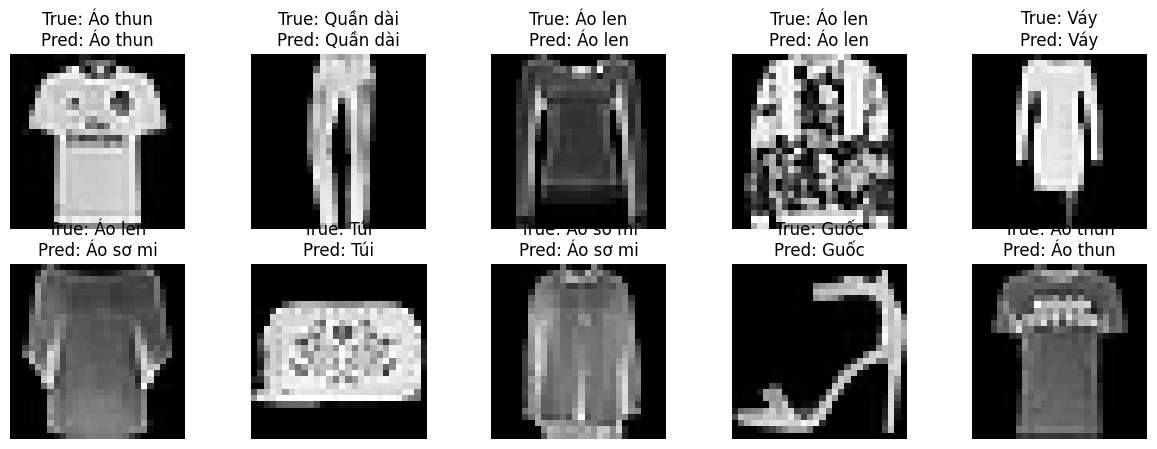

In [12]:
# Hiển thị các mẫu dự đoán
num_images = 10
plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'True: {class_names[test_labels[i]]}\nPred: {class_names[predicted_labels[i]]}')
    plt.axis('off')
plt.show()

## 9. Huấn luyện và đánh giá KNN

In [13]:
# Làm phẳng hình ảnh cho các mô hình ML truyền thống
train_images_flat = train_images.reshape((train_images.shape[0], -1))
test_images_flat = test_images.reshape((test_images.shape[0], -1))

# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_images_flat, train_labels)

# Dự đoán và đánh giá
knn_predictions = knn_model.predict(test_images_flat)
knn_accuracy = accuracy_score(test_labels, knn_predictions)
print(f'KNN Test Accuracy: {knn_accuracy}')

KNN Test Accuracy: 0.8559


## 9.1 Confusion Matrix cho KNN

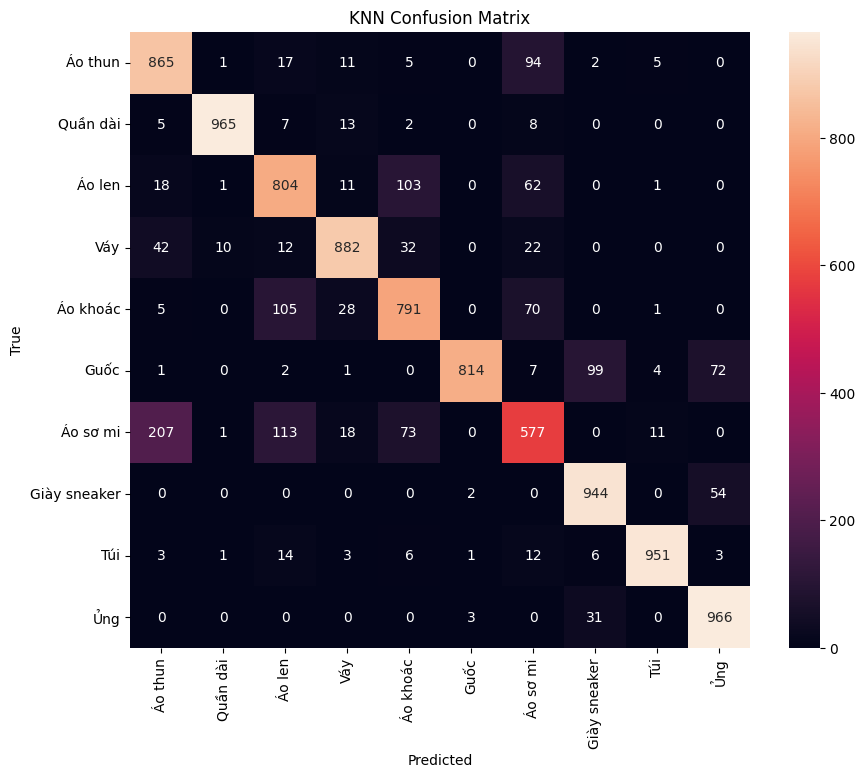

In [14]:
# Confusion Matrix cho KNN
knn_cm = confusion_matrix(test_labels, knn_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(knn_cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

In [15]:
# Báo cáo phân loại cho KNN
print('KNN Classification Report:')
print(classification_report(test_labels, knn_predictions, target_names=class_names))

KNN Classification Report:
              precision    recall  f1-score   support

     Áo thun       0.75      0.86      0.81      1000
    Quần dài       0.99      0.96      0.98      1000
      Áo len       0.75      0.80      0.78      1000
         Váy       0.91      0.88      0.90      1000
    Áo khoác       0.78      0.79      0.79      1000
        Guốc       0.99      0.81      0.89      1000
    Áo sơ mi       0.68      0.58      0.62      1000
Giày sneaker       0.87      0.94      0.91      1000
         Túi       0.98      0.95      0.96      1000
         Ủng       0.88      0.97      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## 10. Huấn luyện và đánh giá Logistic Regression

In [16]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(train_images_flat, train_labels)

# Dự đoán và đánh giá
lr_predictions = lr_model.predict(test_images_flat)
lr_accuracy = accuracy_score(test_labels, lr_predictions)
print(f'Logistic Regression Test Accuracy: {lr_accuracy}')

Logistic Regression Test Accuracy: 0.8519


## 10.1 Confusion Matrix cho Logistic Regression

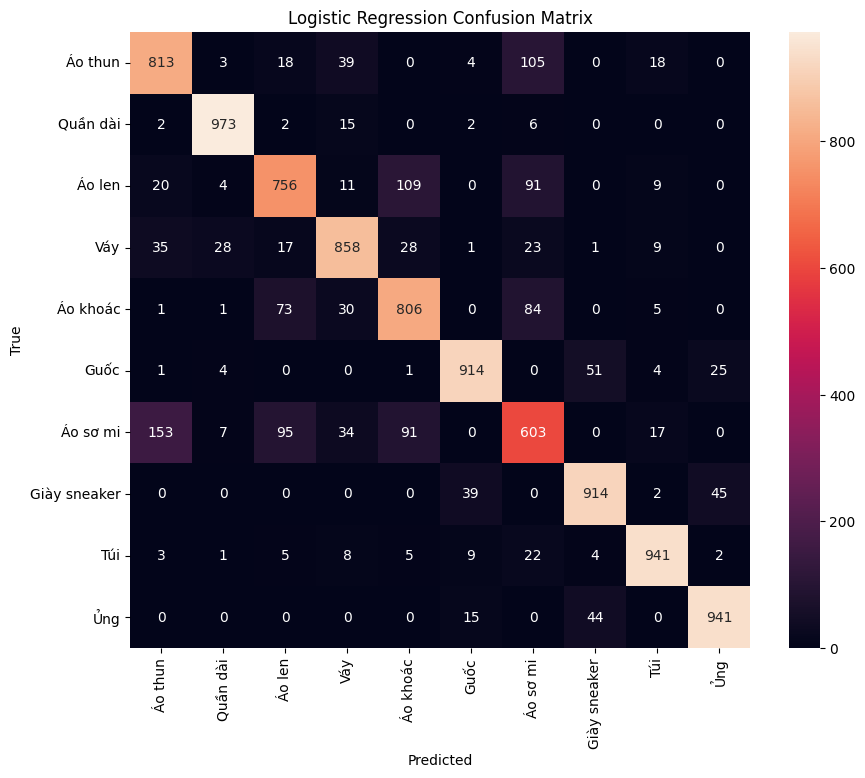

In [17]:
# Confusion Matrix cho Logistic Regression
lr_cm = confusion_matrix(test_labels, lr_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(lr_cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [18]:
# Báo cáo phân loại cho Logistic Regression
print('Logistic Regression Classification Report:')
print(classification_report(test_labels, lr_predictions, target_names=class_names))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Áo thun       0.79      0.81      0.80      1000
    Quần dài       0.95      0.97      0.96      1000
      Áo len       0.78      0.76      0.77      1000
         Váy       0.86      0.86      0.86      1000
    Áo khoác       0.78      0.81      0.79      1000
        Guốc       0.93      0.91      0.92      1000
    Áo sơ mi       0.65      0.60      0.62      1000
Giày sneaker       0.90      0.91      0.91      1000
         Túi       0.94      0.94      0.94      1000
         Ủng       0.93      0.94      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## 11. Biểu đồ so sánh độ chính xác

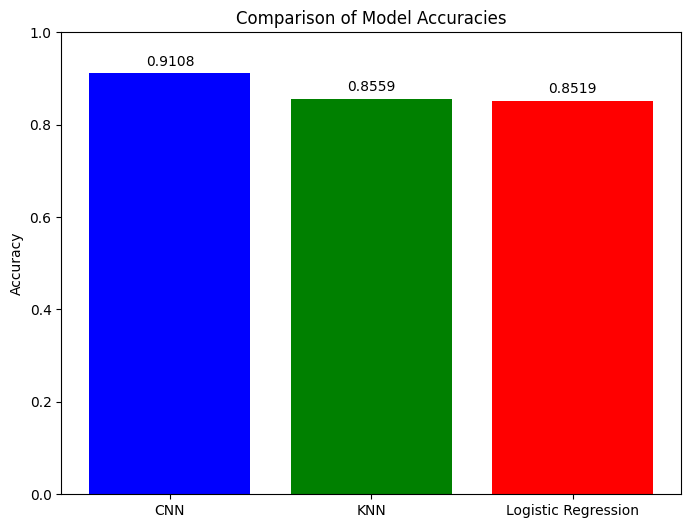

In [19]:
# So sánh độ chính xác của các mô hình
models = ['CNN', 'KNN', 'Logistic Regression']
accuracies = [test_acc, knn_accuracy, lr_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.show()

## 12. Save Model

In [20]:
# Lưu mô hình đã huấn luyện
model.save('fashion_cnn_trained.h5')
print("Model saved as 'fashion_cnn_trained.h5'")

Model saved as 'fashion_cnn_trained.h5'
